# TIM - The Ineference Machine

## This is the first tutorial for TIM, the code-formally-known as PEYOte.
May PEYOte rest in peace

TIM is a fast, easy to use parameter estimation code for gravitational-wave astronomy.  This tutorial will take you through the basics steps of creating a model waveform, injecting that waveform into simulated noise, and then recovering that signal.

In [2]:
%pylab inline
# %matplotlib notebook
import numpy as np
import pylab as plt

%load_ext autoreload
%autoreload 2
import peyote
import corner

import logging
logging.getLogger().addHandler(logging.StreamHandler())
logging.getLogger().setLevel('DEBUG')

Populating the interactive namespace from numpy and matplotlib


## Define a source and simulate data

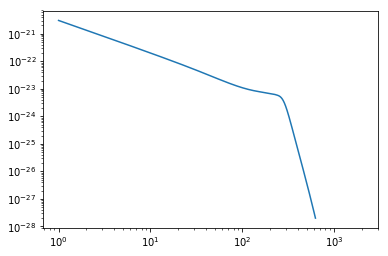

In [3]:
time_duration = 1.
sampling_frequency = 4096.

simulation_parameters = dict(
    mass_1 = 36.,
    mass_2 = 29.,
    spin_1 = [0, 0, 0], 
    spin_2 = [0, 0, 0],
    luminosity_distance = 410.,
    iota = 0., 
    phase = 0., 
    waveform_approximant = 'IMRPhenomPv2',
    reference_frequency = 50.,
    ra = 0,
    dec = 1,
    geocent_time = 0,
    psi=1
    )

source = peyote.source.BinaryBlackHole('BBH', sampling_frequency, time_duration)
hf_signal = source.frequency_domain_strain(simulation_parameters)

plt.loglog(source.frequency_array, np.abs(hf_signal['plus']))
plt.show()

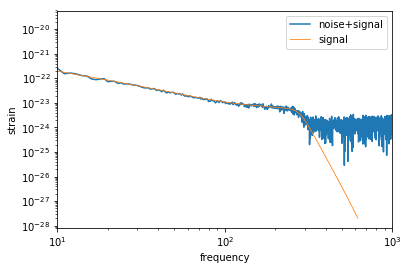

In [4]:
# Simulate the data in H1
IFO = peyote.detector.H1
hf_noise, frequencies = IFO.power_spectral_density.get_noise_realisation(
    sampling_frequency, time_duration)
IFO.set_data(frequency_domain_strain=hf_noise)
IFO.inject_signal(source, simulation_parameters)
IFO.set_spectral_densities(frequencies)
IFO.whiten_data()

# Plot the noise and signal
plt.loglog(frequencies, np.abs(hf_noise), lw=1.5, label='noise+signal')
plt.loglog(frequencies, np.abs(hf_signal['plus']), lw=0.8, label='signal')
plt.xlim(10, 1000)
plt.legend()
plt.xlabel(r'frequency')
plt.ylabel(r'strain')
plt.show()

## Search the data

Here we use an informed prior for `mass_1`, but the default prior for `mass_2` (this is achieved by removing `mass_2` from the input prior dictionary.

In [12]:
%%time

likelihood = peyote.likelihood.likelihood([IFO], source)

prior = simulation_parameters.copy()
prior['mass_1'] = peyote.parameter.Parameter(
    'mass_1', prior=peyote.prior.Uniform(lower=35, upper=37),
    latex_label='$m_1$')
prior.pop('mass_2')

result = peyote.run_sampler(likelihood, prior, sampler='nestle', npoints=100)

Search parameters:
  mass_1 ~ Uniform(upper=37, lower=35, support=2)
  mass_2 ~ PowerLaw(high=100, alpha=0, low=5)
Renaming existing file ./default_label_results.p to ./default_label_results.p.old
Saving result to ./default_label_results.p


CPU times: user 1min 52s, sys: 24 ms, total: 1min 52s
Wall time: 37.3 s


Plot a corner plot

In [ ]:
truths = [simulation_parameters[k] for k in result.search_parameter_keys]
fig = corner.corner(result.samples, labels=result.labels,
                    truths=truths)
fig.show()

The results are saved to disc in a pickle file. To load this

In [13]:
import pickle
with open('default_label_results.p', 'r') as f:
    r = pickle.load(f)